In [2]:
import os, yaml, sys
import numpy as np
import matplotlib.pyplot as plt

ENV = os.getenv("MY_ENV", "dev")
with open("../../config.yaml", "r") as f:
    config = yaml.safe_load(f)
paths = config[ENV]["paths"]
sys.path.append(paths["src_path"])
from general_utils.utils import compute_dRSA, spearman, get_lagplot, get_lagplot_subset
from neural_utils.utils import load_monkey_data, load_stimuli_models, min_max_normalization, random_trials_per_rep, extract_fixation_responses_sing_trial, extract_fixation_responses_sing_stim, extract_all_fixation_responses

In [22]:

monkey_name = "venus"
month = 'sep'
day = 19
resolution_Hz = 100
npx = True
imec_n = 0
normalization = "min_max"
model_name = "alexnet_classifier.2"
day = str(day)
neural_data, gaze_data = load_monkey_data(paths, monkey_name, day, month, resolution_Hz, npx=npx, imec_n=imec_n)
# normalizes them 
if normalization == "min_max":
    n_norm = min_max_normalization(neural_data)
# ADD zscore? robust?
elif normalization == None:
    n_norm = delete_empty_keys(neural_data)

# loads and upsamples the model 
all_models = load_stimuli_models(paths, model_name, n_norm.keys(), resolution_Hz)

# extract_fixation_responses(n_norm, gaze_data, all_models, n_timepts_bef, n_timepts_aft, foreperiod_len_timepts=30)

## Different ways to sample:
- continous, i.e. 1 pseudo-trial per stimulus (decide how to treat repetitions)
- fixation-locked
    - all fixations in a trial, then average across reps of the same trial, then average across stimuli
    - one fixation per trial
        - random fixation, then repeat the analyses for different fixations sets
        - first fixation
        - fixation at a specific moment in time
    - all face fixations vs all non-face fixations

## Random trials

In [4]:
n, g, m = random_trials_per_rep(n_norm, gaze_data, all_models, 100)

In [5]:
n.shape

(64, 100, 83)

In [19]:
dRSA = compute_dRSA(n[:40,:,:], n[300:330, :,:], metric_RDM='euclidean',metric_RDM_model='correlation', metric_dRSA=spearman)
plt.imshow(dRSA)
plt.colorbar()

/Users/tizianocausin/Desktop/virtual_envs/temporal_context/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/tizianocausin/Desktop/virtual_envs/temporal_context/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/tizianocausin/Desktop/virtual_envs/temporal_context/lib/python3.12/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/tizianocausin/Desktop/virtual_envs/temporal_context/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/tizianocausin/Desktop/virtual_envs/temporal_context/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fa

ValueError: Input contains NaN.

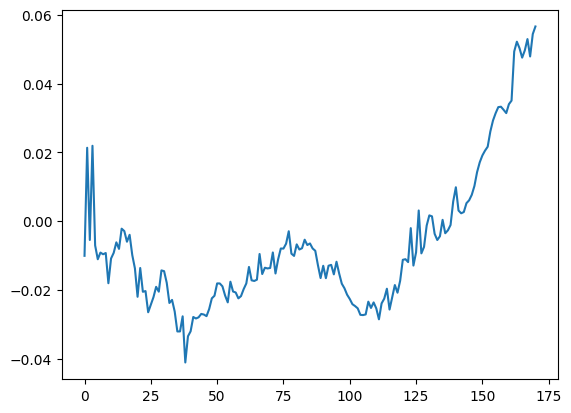

In [7]:
plt.plot(get_lagplot(dRSA, max_lag=85, summary_stat="median"))

## Fixation-locked

### All fixations in all the repetitions

### All fixations in a single stimulus (also multiple repetitions)

In [14]:
neural_data_fix, gaze_data_fix, model_data_fix = extract_fixation_responses_sing_stim(
    n_norm, gaze_data, all_models, fn, 30, 30, stack=1
)

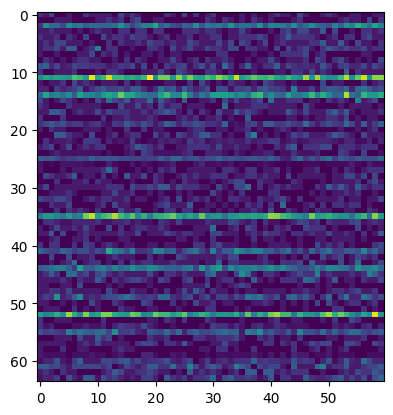

In [17]:
plt.imshow(np.mean(neural_data_fix, axis=2))

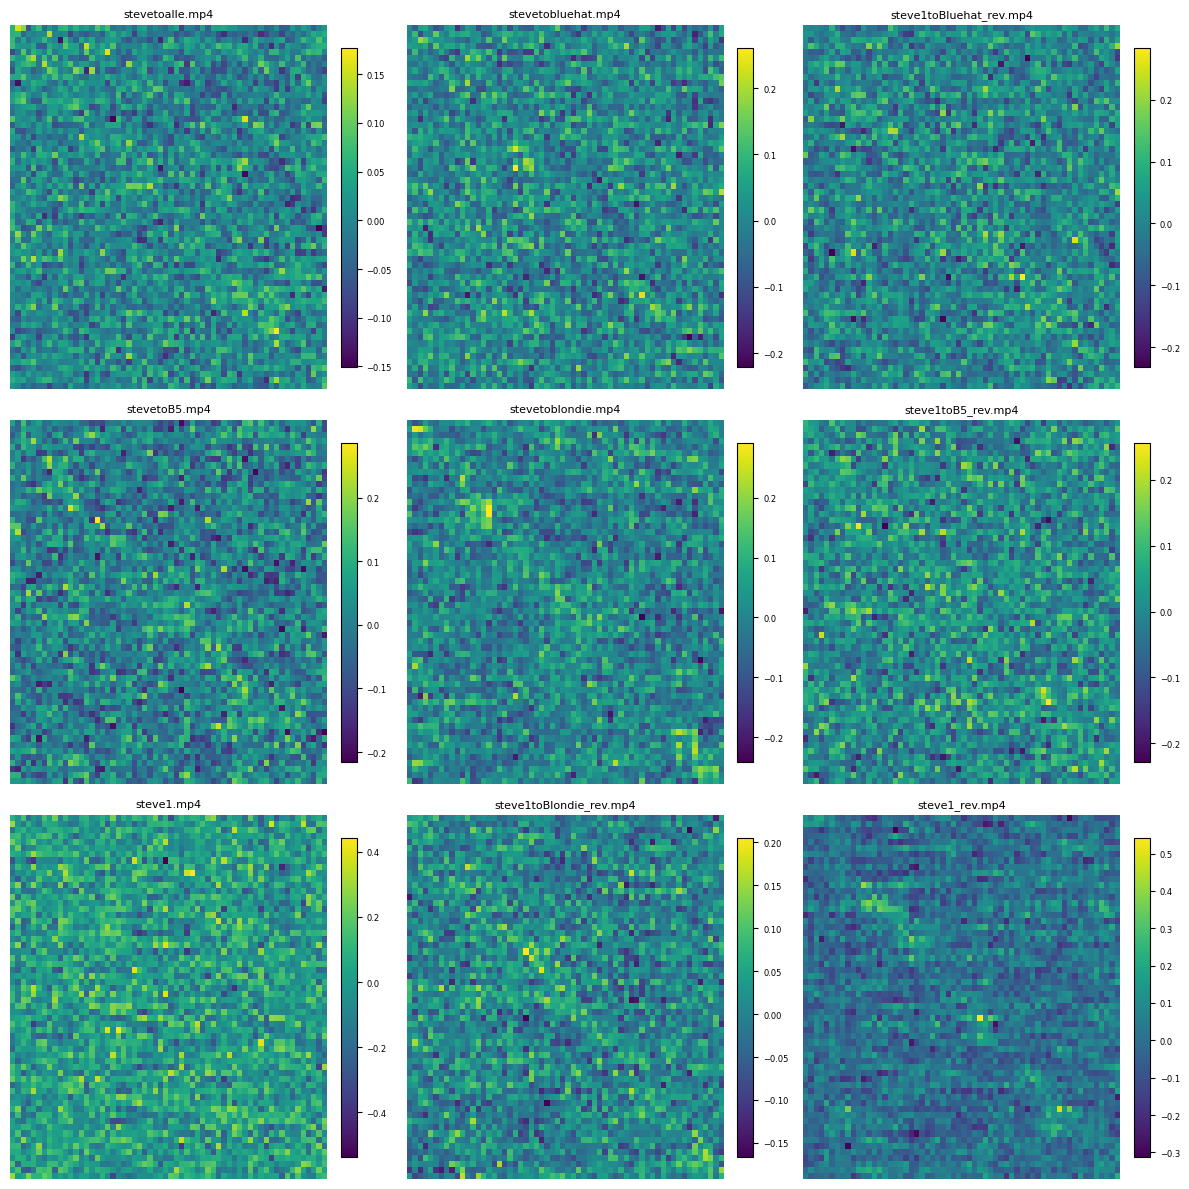

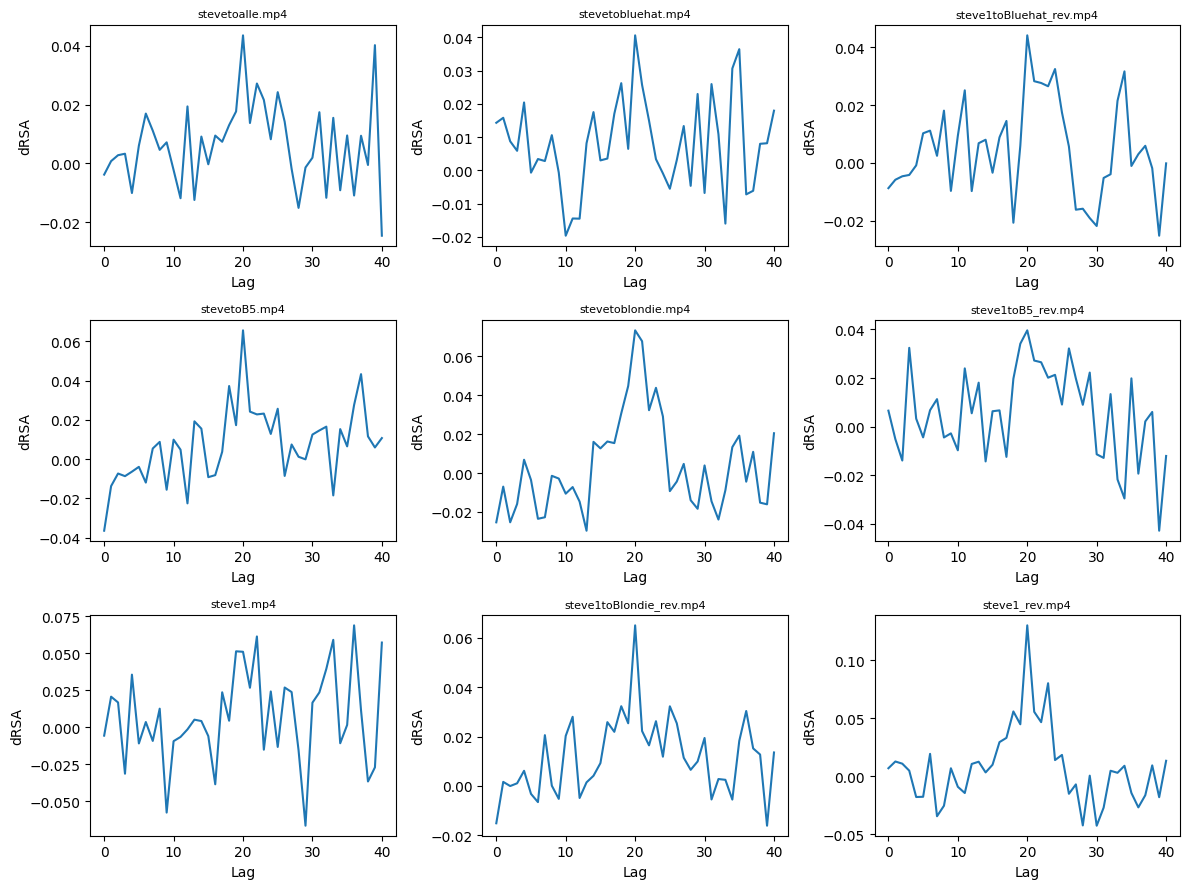

In [23]:
import matplotlib.pyplot as plt
import math

fns = list(n_norm.keys())
n_fns = len(fns)
lagplots = []

# -----------------------------
# FIGURE 1 — HEATMAPS
# -----------------------------

n_cols = math.ceil(math.sqrt(n_fns))
n_rows = math.ceil(n_fns / n_cols)

fig1, axes1 = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))
axes1 = axes1.flatten()

for ax, fn in zip(axes1, fns):
    # compute fixation responses
    neural_data_fix, gaze_data_fix, model_data_fix = extract_fixation_responses_sing_stim(
        n_norm, gaze_data, all_models, fn, 30, 30, stack=1
    )
    if neural_data_fix.shape[2] > 1:
        # compute dRSA
        dRSA = compute_dRSA(
            neural_data_fix[:40, :, :],
            neural_data_fix[300:350, :, :],
            metric_RDM='euclidean',
            metric_RDM_model='euclidean',
            metric_dRSA='correlation'
        )
        lagplots.append(get_lagplot_subset(dRSA, range(30), max_lag=20))

        # plot heatmap
        im = ax.imshow(dRSA, aspect='auto', cmap='viridis')
        ax.set_title(fn, fontsize=8)
        ax.axis('off')

        # colorbar
        cbar = fig1.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.ax.tick_params(labelsize=6)
    else:
        lagplots.append(np.array([]))

# turn off unused axes
for ax in axes1[len(fns):]:
    ax.axis('off')

fig1.tight_layout()


# -----------------------------
# FIGURE 2 — LAG PLOTS
# -----------------------------

fig2, axes2 = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))
axes2 = axes2.flatten()

for ax, fn, lag_vals in zip(axes2, fns, lagplots):
    
    ax.plot(lag_vals)
    ax.set_title(fn, fontsize=8)
    ax.set_xlabel('Lag')
    ax.set_ylabel('dRSA')

# turn off unused axes
for ax in axes2[len(lagplots):]:
    ax.axis('off')

fig2.tight_layout()

# -----------------------------
# SHOW BOTH FIGURES
# -----------------------------
plt.show()

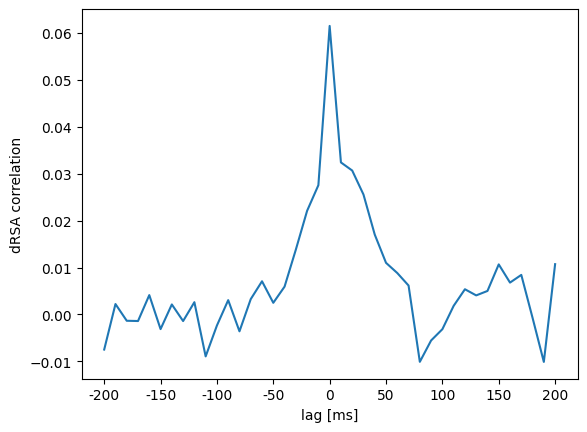

In [31]:
fig, ax = plt.subplots()
ax.plot(np.mean(np.stack(lagplots, axis=-1), axis=-1))
ax.set_ylabel("dRSA correlation")
ax.set_xlabel("lag [ms]")
ax.set_xticks(np.arange(0, 41, 5));
ax.set_xticklabels(np.arange(-20, 21, 5)*10);

### Another way to randomly subsample, very inefficient and prone to errors as it doesn't take care of the boundaries across trials

In [10]:
def concatenate_all_trials_cut_foreperiod(neural_data, foreperiod_len):
    all_trials = []
    for key in neural_data.keys():
        trial = neural_data[key][:, foreperiod_len:, :]
        if trial.shape != (0,):
            trial_flat = trial.reshape(trial.shape[0], -1, order="F")
            all_trials.append(trial_flat)
    tot_data = np.concatenate(all_trials, axis=1)
    return tot_data


In [11]:
neural_concat = concatenate_all_trials_cut_foreperiod(neural_data, 30)
gaze_concat = concatenate_all_trials_cut_foreperiod(gaze_data, 30)


In [12]:
n_trials = 300
len_trial = 400
rand_trials = np.random.randint(neural_concat.shape[1] - len_trial -1, size=n_trials)
tot_neural_trials = []
tot_gaze_trials = []
for trial_onset in rand_trials:
    tot_neural_trials.append(neural_concat[:,trial_onset:trial_onset+len_trial])
    tot_gaze_trials.append(gaze_concat[:,trial_onset:trial_onset+len_trial])
tot_neural_trials = np.stack(tot_neural_trials, axis=-1)
tot_gaze_trials = np.stack(tot_gaze_trials, axis=-1)